In [1]:
import numpy as np
from numpy import matlib as ml
import pandas as pd
import os
import warnings
import librosa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from random import shuffle
import scipy.stats as st

from pynwb import NWBHDF5IO
from pynwb.image import ImageSeries
from pynwb.epoch import TimeIntervals

from sklearn.decomposition import PCA

In [2]:
# ----- SET UP FILE HANDLING -----

computer = 'Dorian'

match computer:
    case 'Dorian':
        nwbpath = 'M:\\scn2a-paper-GWJSNH\\NWB-files'
        
    case 'Ernest':
        nwbpath = 'C:\\Users\\nhogl\\Documents\\GitHub\\scn2a-paper-GWJSNH-code\\NWB'

allnwb = []
allnwb += [os.path.join(nwbpath,each) for each in os.listdir(nwbpath) if each.endswith('.nwb')]

figp=os.path.join('figures','2024July') # where to save figures
saveplots=False

In [5]:
# ----- COLLATE TIME SPENT IN EACH STATE BEHAVIOR AND COUNTS OF EACH POINT BEHAVIOR FOR EACH ASSAY -----

for i,fname in enumerate(allnwb):
    # open file
    io = NWBHDF5IO(os.path.join(nwbpath,fname), mode="r") # <-- open in write to append snippets?
    nwbfile = io.read()
    
    # for sanity check, print out the name of the file being handled
    pathsplit = fname.split('\\')
    recstem = pathsplit[-1].strip('.nwb')
    print(recstem)
    
    # filter out files that don't have complete timelines
    if nwbfile.lab_meta_data['vole_metadata'].timeline_complete:
        data = nwbfile.intervals['annotated_behavior'].to_dataframe()
        df = data.copy()
        df=df[df.behavior!='Start assay']
        counts = df[df.atype=='POINT'].groupby('behavior')['start_time'].count().reset_index(name='number')
        totaldurs = df[df.atype=='STATE'].groupby(['behavior'])['duration'].apply(np.sum).reset_index(name='number')
        combined = pd.concat([counts,totaldurs])
        # PPT label conversion
        if nwbfile.lab_meta_data['vole_metadata'].assay_type=='PPT':
            if nwbfile.lab_meta_data['vole_metadata'].assay_type__partner_chamber=='Left':
                combined.behavior.replace({'Left':'Partner'}, regex=True,inplace=True)
                combined.behavior.replace({'Right':'Stranger'}, regex=True,inplace=True)
            elif nwbfile.lab_meta_data['vole_metadata'].assay_type__partner_chamber=='Right':
                combined.behavior.replace({'Right':'Partner'}, regex=True,inplace=True)
                combined.behavior.replace({'Left':'Stranger'}, regex=True,inplace=True)
            else:
                print('Invalid value for partner chamber.')
        nrbehav = combined.shape[0]
        combined['ET'] = [nwbfile.subject.subject_id]*nrbehav
        combined['sex'] = [nwbfile.subject.sex]*nrbehav
        combined['GT'] = [nwbfile.subject.genotype]*nrbehav
        combined['assay'] = [nwbfile.lab_meta_data['vole_metadata'].assay_type]*nrbehav
        
        if i==0:
            rundf = combined
        else:
            rundf = pd.concat([rundf,combined])
        
    else:
        print('Incomplete timeline; skipping.')

Nov22_Pair15_aggressio
Nov22_Pair15_introductio
Nov22_Pair15_PPT
Nov22_Pair15_reunio
Nov22_Pair15_timedMating
Nov22_Pair16_aggressio
Nov22_Pair16_introductio
Nov22_Pair16_PPT
Nov22_Pair16_reunio
Nov22_Pair16_timedMating
Nov22_Pair17_aggressio
Nov22_Pair17_introductio
Nov22_Pair17_PPT
Nov22_Pair17_reunio
Nov22_Pair17_timedMating
Nov22_Pair18_aggressio
Nov22_Pair18_introductio
Nov22_Pair18_PPT
Nov22_Pair18_reunio
Nov22_Pair18_timedMating
Nov22_Pair19_aggressio
Nov22_Pair19_introductio
Nov22_Pair19_PPT
Nov22_Pair19_reunio
Nov22_Pair19_timedMating
Nov22_Pair1_aggressio
Nov22_Pair1_introductio
Nov22_Pair1_PPT
Nov22_Pair1_reunio
Nov22_Pair1_timedMating
Nov22_Pair21_aggressio
Nov22_Pair21_introductio
Nov22_Pair21_PPT
Nov22_Pair21_reunio
Nov22_Pair21_timedMating
Nov22_Pair22_aggressio
Nov22_Pair22_introductio
Nov22_Pair22_PPT
Nov22_Pair22_reunio
Nov22_Pair22_timedMating
Nov22_Pair23_aggressio
Nov22_Pair23_introductio
Nov22_Pair23_PPT
Nov22_Pair23_reunio
Nov22_Pair23_timedMating
Nov22_Pair24_ag

In [101]:
# ----- SET UP COLORS -----
acols = [[0.627451,   0.57254905, 0.37254903],
        [0.9607843,  0.7882353,  0.15294118],
        [0.34901962, 0.35686275, 0.49019608],
        [0.24705882, 0.30588236, 0.9607843 ]]

fcols = acols[0:2]
mcols = acols[2:]

fpal = sns.color_palette(fcols)
mpal = sns.color_palette(mcols)
apal = sns.color_palette(acols)

In [140]:
# ----- CLEAN UP AND TRANSFORM DATAFRAME -----

# cross reference behaviors to assays
rundf['assay-'] = rundf['assay'].add('-')
rundf['behaviorc'] = rundf['assay-'].add(rundf['behavior'])

# rearrange table so that each individual has a row of data
wide = rundf.pivot(index=['ET','sex','GT'], columns='behaviorc', values='number')

# replace any missing values with zeros (as they did not occur)
filled = wide.fillna(0)

In [30]:
# ----- PCA ON ALL DATA TOGETHER -----
pca = PCA(n_components=2,whiten=True)
comp = pca.fit(filled).transform(filled)
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_))

# add to dataframe for easy plotting
filled['PCA1']=comp[:,0]
filled['PCA2']=comp[:,1]

explained variance ratio (first two components): [0.63995406 0.16880376]


explained variance ratio (first two components): [0.64148279 0.21179269]


<AxesSubplot: xlabel='PCA1', ylabel='PCA2'>

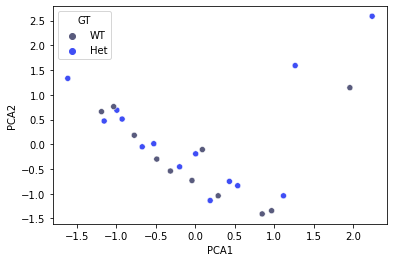

In [141]:
# ----- PCA FOR MALES ONLY -----
mdf = filled.loc[pd.IndexSlice[:, ['M']], :].copy()
# mdf = filled[filled.sex=='M']
mpca = PCA(n_components=2,whiten=True)
mcomp = mpca.fit(mdf).transform(mdf)
print(
    "explained variance ratio (first two components): %s"
    % str(mpca.explained_variance_ratio_))
mdf['PCA1'] = mcomp[:,0]
mdf['PCA2'] = mcomp[:,1]
sns.scatterplot(data=mdf , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=mpal)

explained variance ratio (first two components): [0.74055925 0.15471612]


<AxesSubplot: xlabel='PCA1', ylabel='PCA2'>

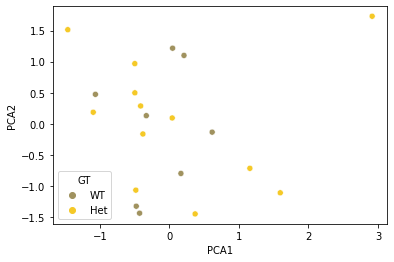

In [142]:
# ----- PCA FOR FEMALES ONLY -----
fdf = filled.loc[pd.IndexSlice[:, ['F']], :].copy()
fpca = PCA(n_components=2,whiten=True)
fcomp = fpca.fit(fdf).transform(fdf)
print(
    "explained variance ratio (first two components): %s"
    % str(fpca.explained_variance_ratio_))
fdf['PCA1'] = fcomp[:,0]
fdf['PCA2'] = fcomp[:,1]
sns.scatterplot(data=fdf , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=fpal)

In [114]:
# ----- DROP METADATA OUT OF INDEX -----
# filled = filled.reset_index(level=['sex', 'GT'])
filled

behaviorc,sex,GT,PPT-Attack Partner,PPT-Attack Stranger,PPT-Center,PPT-Huddle Partner,PPT-Huddle Stranger,PPT-Interact Partner,PPT-Interact Stranger,PPT-Partner,...,timedMating-Aggression receipt,timedMating-Ejaculate,timedMating-Huddle,timedMating-Intromission,timedMating-Investigate,timedMating-Mount,timedMating-No interaction,timedMating-Sniff,timedMating-Strike,timedMating-Tussle
ET,,,,,,,,,,,,,,,,,,,,,
B6611,M,Het,0.0,0.0,746.226,3583.733,141.490,312.092,33.990,1192.287,...,0.0,1.0,66.142,363.201,65.781,69.454,1084.970,150.096,0.0,0.000
B6613,M,WT,0.0,1.0,1088.860,3878.976,613.914,384.763,333.412,3451.449,...,2.0,0.0,24.484,310.941,37.036,66.554,1142.798,217.907,0.0,0.000
B6614,F,Het,1.0,0.0,759.090,6924.177,325.860,231.231,284.975,1171.884,...,0.0,0.0,547.620,0.000,102.970,0.000,1104.580,44.461,1.0,0.000
B6615,F,WT,0.0,0.0,522.786,8337.018,11.251,158.851,92.355,1414.811,...,0.0,0.0,659.552,0.000,50.345,0.000,1052.188,37.730,0.0,0.000
B6616,M,WT,0.0,1.0,1397.321,1384.563,463.983,222.084,351.941,3669.209,...,0.0,0.0,949.002,44.741,117.309,16.501,566.972,105.226,0.0,0.000
B8002,F,Het,1.0,13.0,2597.902,2503.422,0.000,207.904,5.500,1990.001,...,0.0,2.0,25.578,133.723,19.862,26.809,1581.582,11.237,2.0,0.999
B8003,F,WT,0.0,0.0,488.417,5013.233,1755.192,209.960,214.162,827.622,...,0.0,0.0,1589.389,0.000,4.828,0.000,197.362,8.365,0.0,0.000
B8004,F,Het,0.0,1.0,296.205,8488.707,25.003,101.652,1.977,1694.157,...,0.0,0.0,262.730,106.248,17.379,1.244,1396.512,15.706,0.0,0.000
B8018,F,Het,0.0,0.0,449.856,7080.643,407.987,233.083,377.357,843.594,...,0.0,0.0,744.921,0.000,91.747,0.000,911.909,51.208,0.0,0.000


In [126]:
# ----- SET UP PARAMETERS -----
prosocialnames = ['huddle','AG sniff','non AG sniff']
prosocialetho = ['Huddle','Sniff','Investigate']
ho = ['WT','Het']
saveplots = True

Text(0.5, 1.04, 'Introduction')

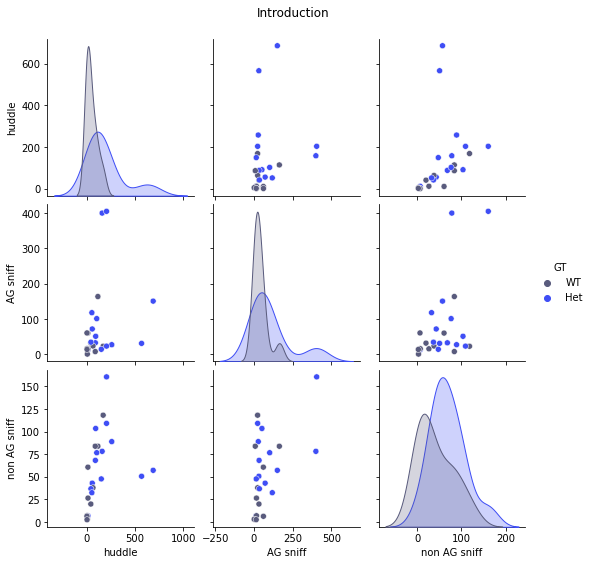

In [136]:
# ----- INTRODUCTION PAIR PLOTS -----
assay = 'introduction'
assaybehavs = [assay+'-'+name for name in prosocialetho]
assaybehavs += ['GT']
namedict = dict(zip(assaybehavs, prosocialnames))
sliced = filled[filled.sex=='M'][assaybehavs]
thisdf = sliced.rename(columns=namedict)
g = sns.pairplot(thisdf,hue='GT',hue_order=ho,palette=mpal)
g.fig.suptitle('Introduction', y=1.04)
# if saveplots:
#     plt.savefig(os.path.join(figp,'intro_males_prosocial_pairplots.pdf'))

Text(0.5, 1.04, 'Aggression')

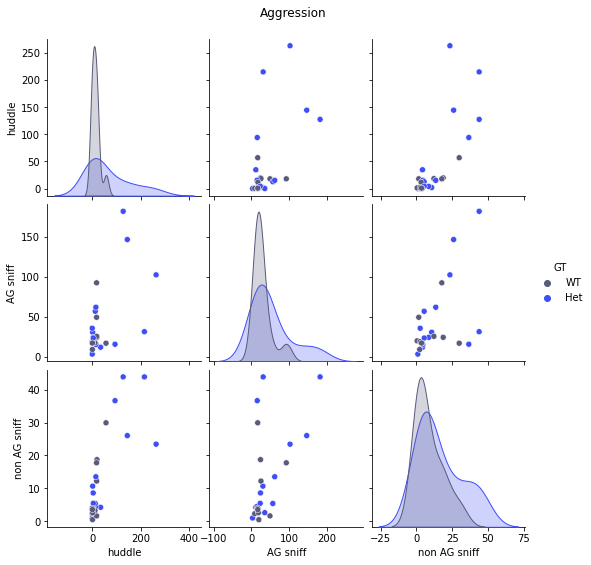

In [135]:
# ----- STRANGER AGGRESSION PLOTS -----
assay = 'aggression'
assaybehavs = [assay+'-'+name for name in prosocialetho]
assaybehavs += ['GT']
namedict = dict(zip(assaybehavs, prosocialnames))
sliced = filled[filled.sex=='M'][assaybehavs]
thisdf = sliced.rename(columns=namedict)
g = sns.pairplot(thisdf,hue='GT',hue_order=ho,palette=mpal)
g.fig.suptitle('Aggression', y=1.04)
# if saveplots:
#     plt.savefig(os.path.join(figp,'aggression_males_prosocial_pairplots.pdf'))

Text(0.5, 1.02, 'Introduction, aggression, reunion')

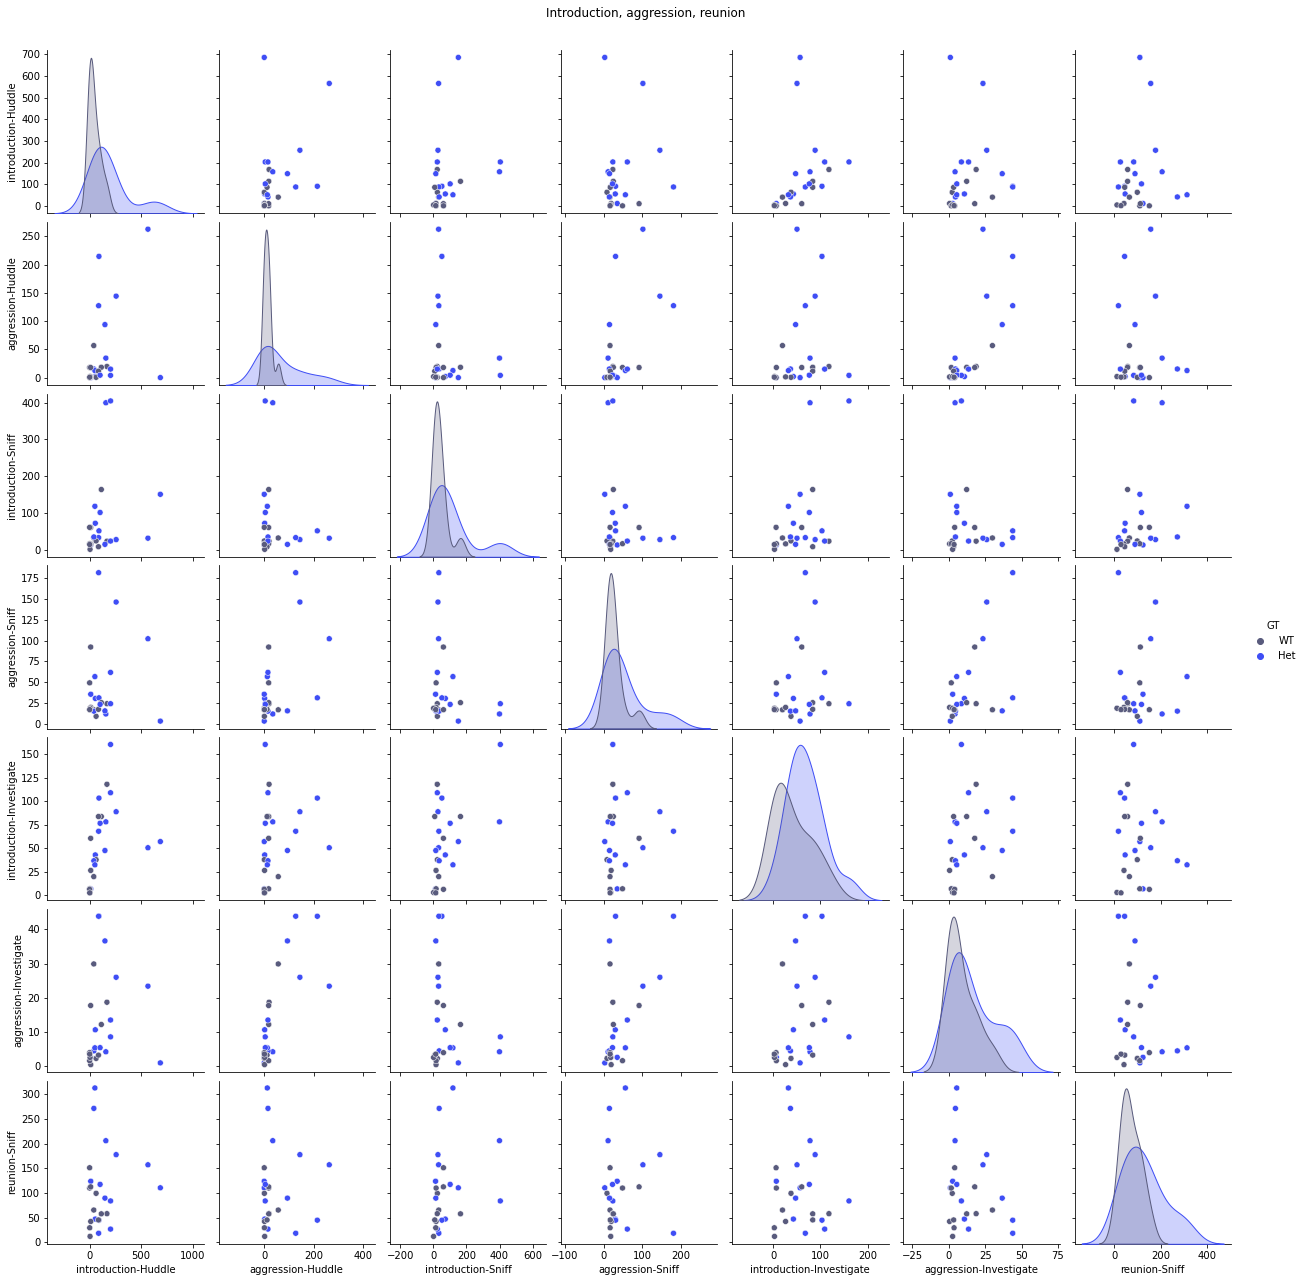

In [138]:
# ----- PAIRPLOTS ACROSS ASSAYS, CHERRY PICKED METRICS -----
assays = ['introduction','aggression']
assaybehavs = [assay+'-'+name for name in prosocialetho for assay in assays]
assaybehavs += ['reunion-Sniff']
assaybehavs += ['GT']
sliced = filled[filled.sex=='M'][assaybehavs]
thisdf = sliced
g = sns.pairplot(thisdf,hue='GT',hue_order=ho,palette=mpal)
g.fig.suptitle('Introduction, aggression, reunion', y=1.02)
# if saveplots:
#     plt.savefig(os.path.join(figp,'intro-reunion-aggression_males_prosocial_pairplots.pdf'))

explained variance ratio (first two components): [0.55692988 0.22320667]


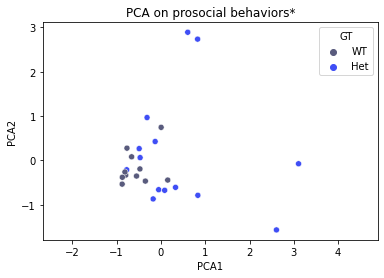

In [129]:
# ----- TRY PCA ON INTERESTING METRICS -----
assays = ['introduction','aggression']
assaybehavs = [assay+'-'+name for name in prosocialetho for assay in assays]
assaybehavs += ['reunion-Sniff']
sliced = filled[filled.sex=='M'][assaybehavs]
sigpca = PCA(n_components=2,whiten=True)
sigcomp = sigpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(sigpca.explained_variance_ratio_))
sliced['PCA1'] = sigcomp[:,0]
sliced['PCA2'] = sigcomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=mpal)
tp.axis('equal')
tp.set_title('PCA on prosocial behaviors*')
if saveplots:
    plt.savefig(os.path.join(figp,'PCA_males_prosocial_cherryPicked.pdf'))

explained variance ratio (first two components): [0.72129899 0.14621143]


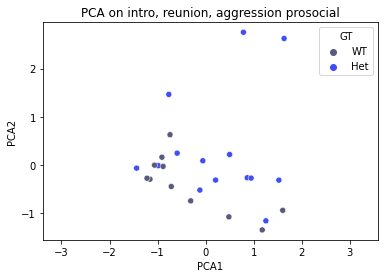

In [130]:
# ----- TRY PCA ON INTERESTING METRICS -----
assays = ['introduction','aggression','reunion']
assaybehavs = [assay+'-'+name for name in prosocialetho for assay in assays]
sliced = filled[filled.sex=='M'][assaybehavs]
prosocpca = PCA(n_components=2,whiten=True)
prosoccomp = prosocpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(prosocpca.explained_variance_ratio_))
sliced['PCA1'] = prosoccomp[:,0]
sliced['PCA2'] = prosoccomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=mpal)
tp.axis('equal')
tp.set_title('PCA on intro, reunion, aggression prosocial')
if saveplots:
    plt.savefig(os.path.join(figp,'PCA_males_prosocial_intro-reunion-aggression.pdf'))